<a href="https://colab.research.google.com/github/BU-Spark/ds-schilde-dod-contracts/blob/yuluj/yuluj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class USASpendingAPI:
    def __init__(self, naics_code):
        self.base_url = "https://api.usaspending.gov/api/v2/"
        self.agency_filter = {
            "type": "awarding",
            "tier": "toptier",
            "name": "Department of Defense"
        }
        self.naics_code = naics_code

    def fetch_spending_data(self, from_date, to_date):
        endpoint = f"search/spending_by_category/naics/{self.naics_code}"
        request_payload = {
            "filters": {
                "time_period": [{"start_date": from_date, "end_date": to_date}],
                "naics_codes": {"require": [self.naics_code]},
                "agencies": [self.agency_filter]
            },
            "category": "naics",
            "limit": 5,
            "page": 1
        }
        response = requests.post(self.base_url + endpoint, json=request_payload)
        response.raise_for_status()  # Will raise an exception for HTTP errors.
        data = response.json()
        return data['results'] if 'results' in data else []

    def fetch_largest_contract(self, fiscal_year):
        endpoint = "search/spending_by_award/"
        fiscal_start = f"{fiscal_year}-10-01"
        fiscal_end = f"{fiscal_year+1}-09-30"
        request_payload = {
            "filters": {
                "time_period": [{"start_date": fiscal_start, "end_date": fiscal_end}],
                "naics_codes": [self.naics_code],
                "agencies": [self.agency_filter],
                "award_type_codes": ["C"]
            },
            "fields": ["Award Amount", "Recipient Name"],
            "limit": 100,
            "page": 1,
            "order": "desc",
            "sort": "Award Amount"
        }
        response = requests.post(self.base_url + endpoint, json=request_payload)
        response.raise_for_status()
        contract_data = response.json()
        return contract_data['results'] if 'results' in contract_data else []

    def annual_spending(self, start_year, end_year):
        yearly_spending = {}
        for year in range(start_year, end_year + 1):
            from_date, to_date = f"{year}-01-01", f"{year+1}-01-01"
            data = self.fetch_spending_data(from_date, to_date)
            yearly_spending[year] = data[0]['amount'] if data else 0
        return yearly_spending

    def largest_annual_contracts(self, from_year, to_year):
        contracts = {}
        for year in range(from_year, to_year + 1):
            data = self.fetch_largest_contract(year)
            contracts[year] = data[0] if data else None
        return contracts

In [ ]:
def visualize_spending(data, naics_code):
    df = pd.DataFrame({'Year': list(data.keys()), 'Spending Amount': list(data.values())})
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Year", y="Spending Amount", data=df, palette="viridis")
    plt.xlabel('Year')
    plt.ylabel('Spending Amount')
    plt.title(f'Annual Spending for NAICS Code {naics_code}')
    for patch in ax.patches:
        ax.annotate(f"${patch.get_height():,.2f}", (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                    ha='center', va='center', fontsize=9, color='white', xytext=(0, 10), textcoords='offset points')
    plt.show()

In [ ]:
def visualize_contracts(data, naics_code):
    years = list(data.keys())
    contract_values = [item['Award Amount'] if item else 0 for item in data.values()]
    df = pd.DataFrame({'Year': years, 'Contract Value': contract_values})
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Year", y="Contract Value", data=df, palette="viridis")
    plt.xlabel('Year')
    plt.ylabel('Contract Value')
    plt.title(f'Largest Contracts for NAICS Code {naics_code}')
    for patch in ax.patches:
        ax.annotate(f"${patch.get_height():,.2f}", (patch.get_x() + patch.get_width() / 2., patch.get_height()),
                    ha='center', va='center', fontsize=9, color='white', xytext=(0, 10), textcoords='offset points')
    plt.show()

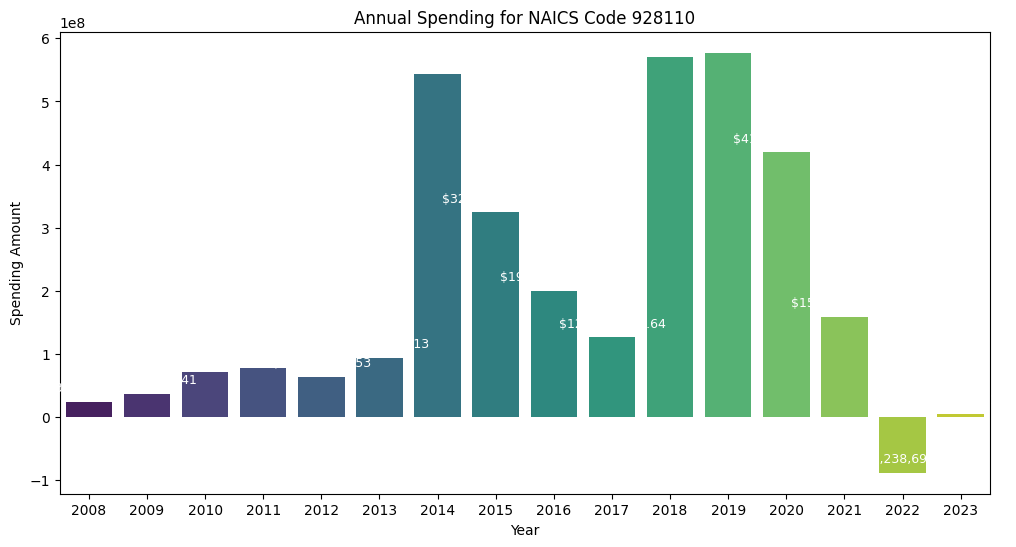

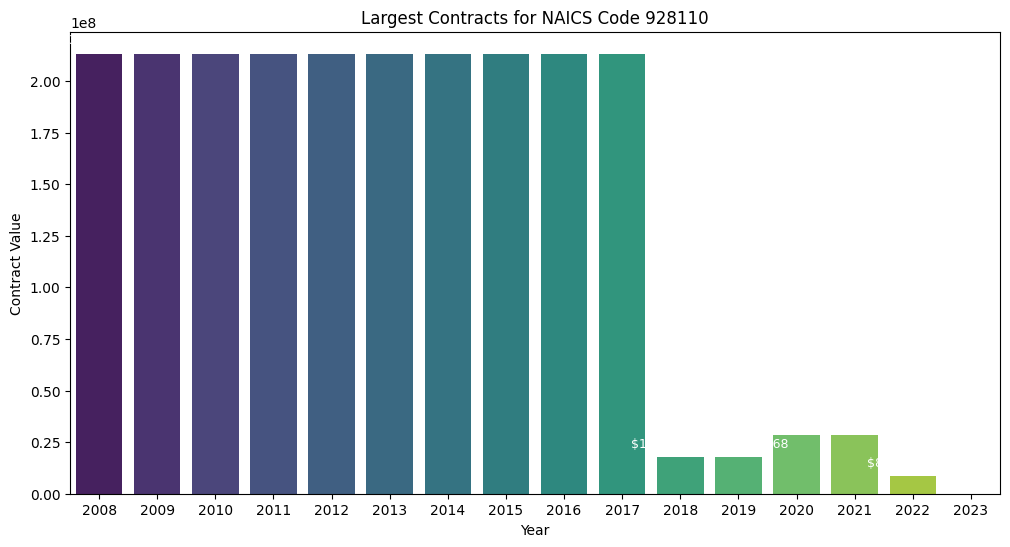

Year 2008: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2009: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2010: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2011: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2012: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2013: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2014: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2015: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2016: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2017: Highest Contract - $213,238,847.00, Recipient - BROWN & ROOT SERVICES
Year 2018: Highest Contract - $17,578,137.68, Recipient - GEORGIA TECH APPLIED RESEARCH CORPORATION
Year 2019: Highest Contract - $17,578,137.68, Recipient - GEORGIA TECH APPLIED RESEARCH CO

In [ ]:
def main():
    naics_code = "928110"
    psc_code = "U008"
    api_client = USASpendingAPI(naics_code)

    spending_data = api_client.annual_spending(2008, 2023)
    visualize_spending(spending_data, naics_code)

    contract_data = api_client.largest_annual_contracts(2008, 2023)
    visualize_contracts(contract_data, naics_code)
    for year, contract in contract_data.items():
        if contract:
            print(f"Year {year}: Highest Contract - ${contract['Award Amount']:,.2f}, Recipient - {contract['Recipient Name']}")

main()

### Stacked bar chart for 9281

In [ ]:
def fetch_annual_spending_for_naics_codes(naics_codes, from_year, to_year):
    api_clients = {code: USASpendingAPI(code) for code in naics_codes}

    annual_spending_data = {code: {} for code in naics_codes}

    for code, api_client in api_clients.items():
        annual_spending_data[code] = api_client.annual_spending(from_year, to_year)

    return annual_spending_data

def main():
    naics_codes = ["928110", "928120"]

    # Retrieve annual spending data for both NAICS codes
    spending_data = fetch_annual_spending_for_naics_codes(naics_codes, 2008, 2023)

    return spending_data

# This will return the spending data
spending_data = main()


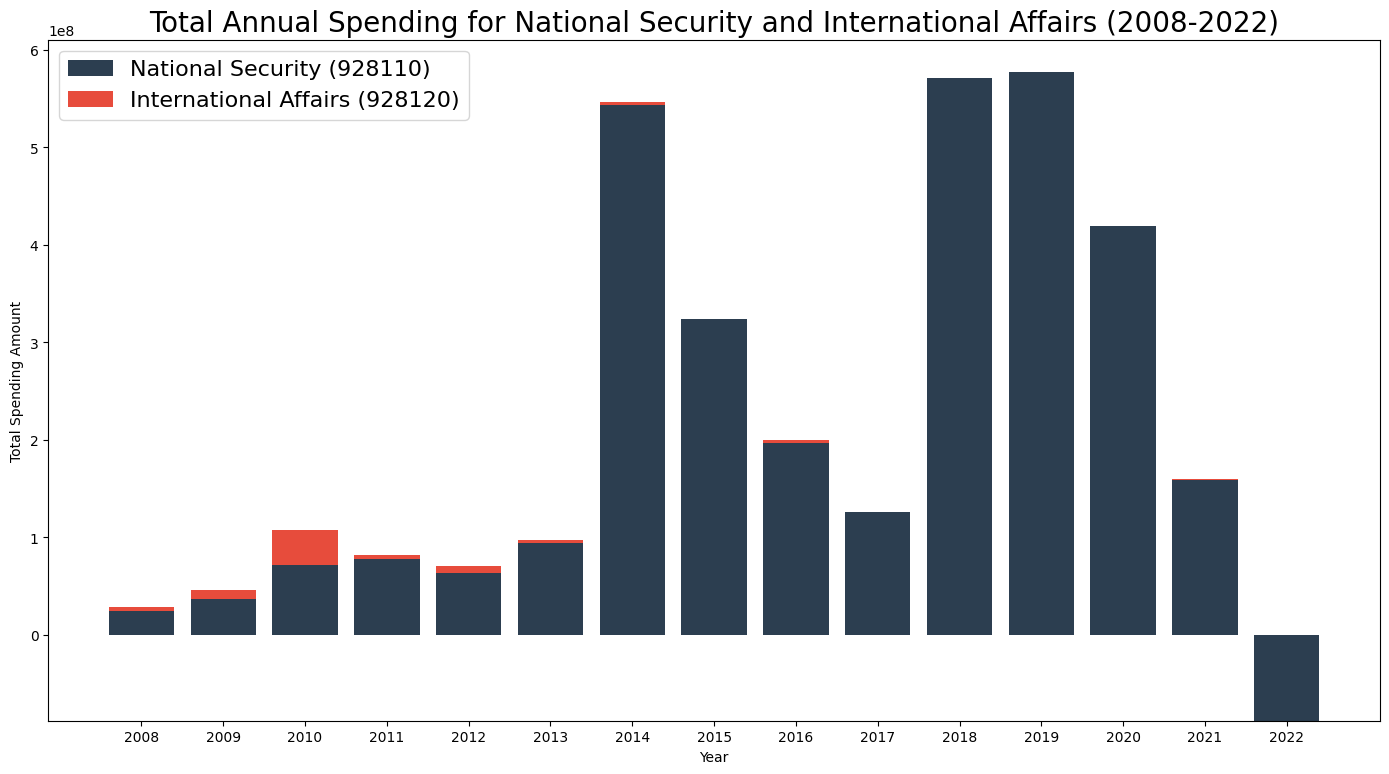

In [ ]:
import matplotlib.pyplot as plt

years = list(range(2008, 2023))
amounts_928110 = [spending_data["928110"][year] for year in years]
amounts_928120 = [spending_data["928120"][year] for year in years]

# Plotting the stacked bar chart with a professional color palette
plt.figure(figsize=(14, 8))
colors = ["#2C3E50", "#E74C3C"]  # Professional color palette

p1 = plt.bar(years, amounts_928110, label='National Security (928110)', color=colors[0])
p2 = plt.bar(years, amounts_928120, bottom=amounts_928110, label='International Affairs (928120)', color=colors[1])

plt.xlabel('Year')
plt.ylabel('Total Spending Amount')
plt.title('Total Annual Spending for National Security and International Affairs (2008-2022)', fontsize=20)
plt.xticks(years)
plt.legend(fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
class USASpendingAPI(USASpendingAPI):  # Extending the existing class

    def top_vendors_over_time(self, from_year, to_year):
        vendor_totals = {}

        for year in range(from_year, to_year + 1):
            contracts_for_year = self.fetch_largest_contract(year)

            for contract in contracts_for_year:
                vendor = contract['Recipient Name']
                amount = contract['Award Amount']

                if vendor in vendor_totals:
                    vendor_totals[vendor] += amount
                else:
                    vendor_totals[vendor] = amount

        # Sort vendors based on total accumulated contract amount
        sorted_vendors = sorted(vendor_totals.items(), key=lambda x: x[1], reverse=True)

        return sorted_vendors

# Fetch the top vendors for the fiscal year range:
api_client = USASpendingAPI("9281")  # For NAICS group 9281
top_vendors = api_client.top_vendors_over_time(2008, 2023)

# Display the top vendors and their accumulated contract amounts
for vendor, amount in top_vendors:
    print(f"{vendor}: ${amount:,.2f}")


BROWN & ROOT SERVICES: $2,132,388,470.00
GEORGIA TECH APPLIED RESEARCH CORPORATION: $556,475,320.28
LEIDOS, INC.: $439,353,182.96
THALES USA, INC.: $401,188,942.69
SCIENCE APPLICATIONS INTERNATIONAL CORPORATION: $166,426,396.71
KELLOGG BROWN & ROOT, INC: $132,387,891.66
SR TECHNOLOGIES INC: $61,637,825.30
BROWN INTERNATIONAL CORPORATION: $7,118,458.40
BECHTEL NATIONAL, INC.: $7,083,068.00
THALES DEFENSE & SECURITY INC: $5,493,997.70
MISCELLANEOUS FOREIGN AWARDEES: $5,392,216.67
MITTARFEQARFIIT GREENLAND AIRPORTS: $4,392,274.83
FGS, LLC: $3,258,917.71
ICONS INTERNATIONAL CONSULTANTS, L.L.C.: $1,869,070.70
AIR FORCE, UNITED STATES DEPARTMENT OF THE: $1,389,986.50
INTERNATIONAL SURVEILLANCE TECHNOLOGY, INC: $94,654.29
CENTER FOR STRATEGIC AND BUDGETARY ASSESSMENTS: $2,056.16


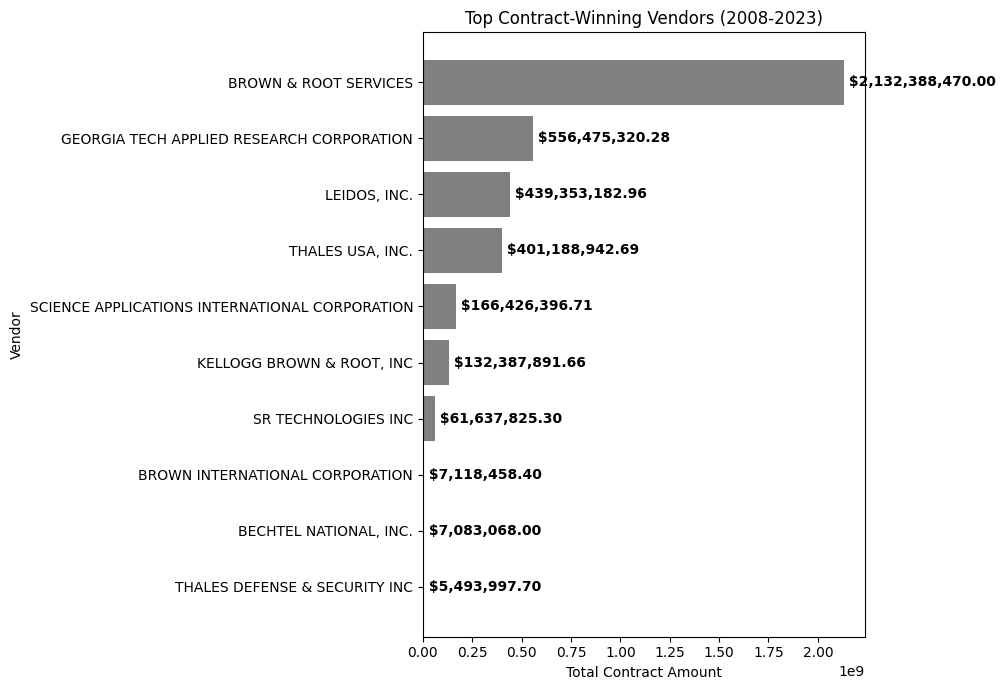

In [ ]:
import matplotlib.pyplot as plt

class USASpendingAPI(USASpendingAPI):  # Extending the existing class

    def top_vendors_over_time(self, from_year, to_year, top_n=10):
        vendor_totals = {}

        for year in range(from_year, to_year + 1):
            contracts_for_year = self.fetch_largest_contract(year)

            for contract in contracts_for_year:
                vendor = contract['Recipient Name']
                amount = contract['Award Amount']

                if vendor in vendor_totals:
                    vendor_totals[vendor] += amount
                else:
                    vendor_totals[vendor] = amount

        # Sort vendors based on total accumulated contract amount and get the top N vendors
        sorted_vendors = sorted(vendor_totals.items(), key=lambda x: x[1], reverse=True)[:top_n]

        return sorted_vendors

    def visualize_top_vendors(self, from_year, to_year, top_n=10):
        top_vendors = self.top_vendors_over_time(from_year, to_year, top_n)

        vendors = [item[0] for item in top_vendors]
        amounts = [item[1] for item in top_vendors]

        plt.figure(figsize=(10, 7))
        plt.barh(vendors, amounts, color='gray')  # Change bar color to gray
        plt.xlabel('Total Contract Amount')
        plt.ylabel('Vendor')
      #  plt.title('Top Contract-Winning Vendors (2008-2023)')

        # Annotate the bars with the contract amounts
        for i, v in enumerate(amounts):
            plt.text(v, i, f" ${v:,.2f}", va='center', fontweight='bold', color='black')

        plt.gca().invert_yaxis()  # To display the top vendor at the top
        plt.tight_layout()
        plt.show()

# Visualize the top vendors for the fiscal year range:
api_client = USASpendingAPI("9281")  # For NAICS group 9281
api_client.visualize_top_vendors(2008, 2023, top_n=10)



In [ ]:
def fetch_annual_spending_for_naics_codes(naics_codes, from_year, to_year):
    api_clients = {code: USASpendingAPI(code) for code in naics_codes}

    annual_spending_data = {code: {} for code in naics_codes}

    for code, api_client in api_clients.items():
        annual_spending_data[code] = api_client.annual_spending(from_year, to_year)

    return annual_spending_data

def main():
    naics_codes = ['5416', '9211', '9221', '9281']

    # Retrieve annual spending data for both NAICS codes
    spending_data = fetch_annual_spending_for_naics_codes(naics_codes, 2008, 2023)

    return spending_data

# This will return the spending data
spending_data = main()


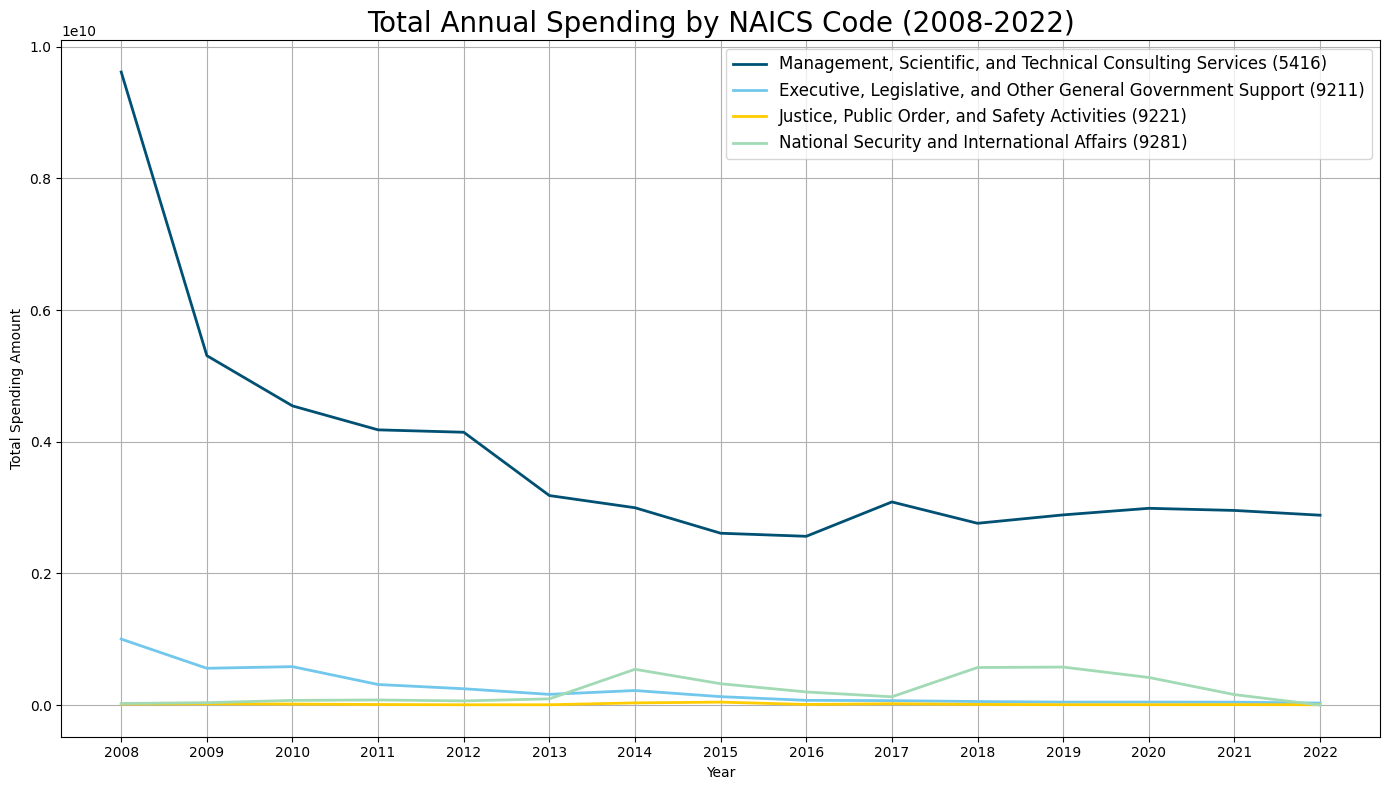

In [ ]:
import matplotlib.pyplot as plt

years = list(range(2008, 2023))
amounts_5416 = [spending_data["5416"][year] for year in years]
amounts_9211 = [spending_data["9211"][year] for year in years]
amounts_9221 = [spending_data["9221"][year] for year in years]
amounts_9281 = [spending_data["9281"][year] for year in years]

# Plotting the line chart with a more professional color palette
plt.figure(figsize=(14, 8))
colors = ["#005073", "#71c7ec", "#ffcc00", "#a1dab4"]  # Updated professional color palette

# Plotting smooth lines without markers
plt.plot(years, amounts_5416, label='Management, Scientific, and Technical Consulting Services (5416)', color=colors[0], linewidth=2)
plt.plot(years, amounts_9211, label='Executive, Legislative, and Other General Government Support (9211)', color=colors[1], linewidth=2)
plt.plot(years, amounts_9221, label='Justice, Public Order, and Safety Activities (9221)', color=colors[2], linewidth=2)
plt.plot(years, amounts_9281, label='National Security and International Affairs (9281)', color=colors[3], linewidth=2)

plt.xlabel('Year')
plt.ylabel('Total Spending Amount')
plt.title('Total Annual Spending by NAICS Code (2008-2022)', fontsize=20)
plt.xticks(years)
plt.legend(loc='upper right', fontsize=12)

plt.grid(True)  # Adding a grid for better readability
plt.tight_layout()
plt.show()


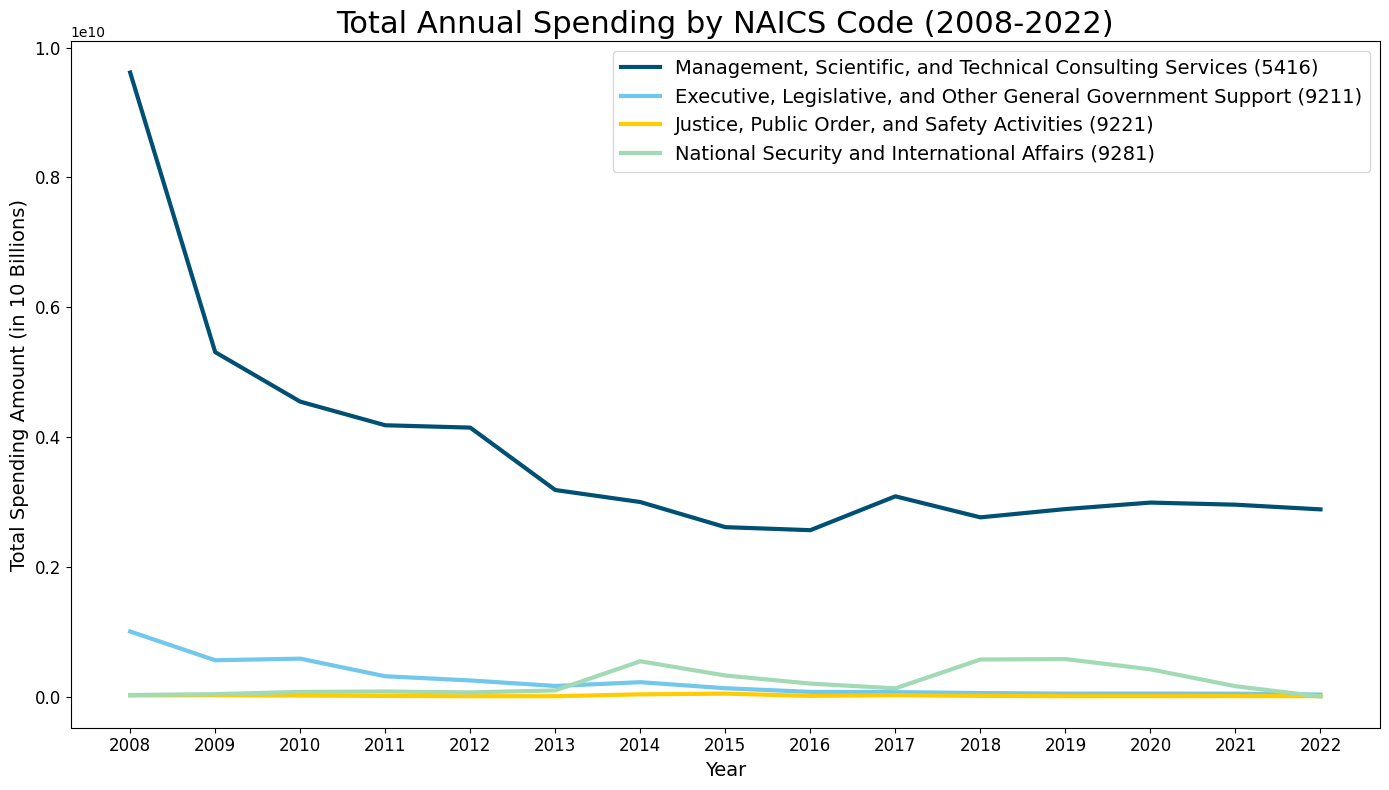

In [ ]:
import matplotlib.pyplot as plt

years = list(range(2008, 2023))
amounts_5416 = [spending_data["5416"][year] for year in years]
amounts_9211 = [spending_data["9211"][year] for year in years]
amounts_9221 = [spending_data["9221"][year] for year in years]
amounts_9281 = [spending_data["9281"][year] for year in years]

# Plotting the line chart with a more professional color palette
plt.figure(figsize=(14, 8))
colors = ["#005073", "#71c7ec", "#ffcc00", "#a1dab4"]  # Professional color palette

# Plotting thicker lines
plt.plot(years, amounts_5416, label='Management, Scientific, and Technical Consulting Services (5416)', color=colors[0], linewidth=3)
plt.plot(years, amounts_9211, label='Executive, Legislative, and Other General Government Support (9211)', color=colors[1], linewidth=3)
plt.plot(years, amounts_9221, label='Justice, Public Order, and Safety Activities (9221)', color=colors[2], linewidth=3)
plt.plot(years, amounts_9281, label='National Security and International Affairs (9281)', color=colors[3], linewidth=3)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Spending Amount (in 10 Billions)', fontsize=14)
plt.title('Total Annual Spending by NAICS Code (2008-2022)', fontsize=22)
plt.xticks(years, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)


plt.tight_layout()
plt.show()


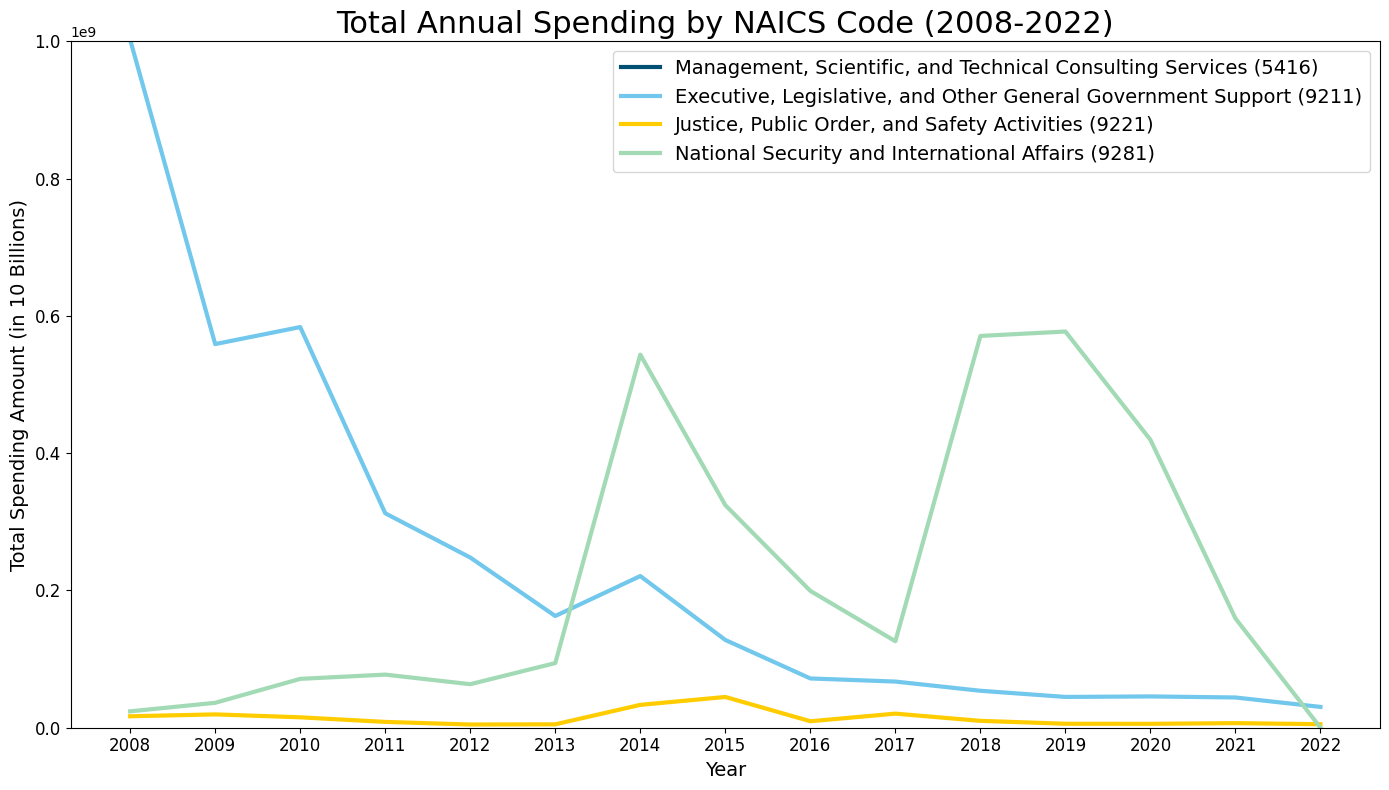

In [ ]:
import matplotlib.pyplot as plt

years = list(range(2008, 2023))
amounts_5416 = [spending_data["5416"][year] for year in years]
amounts_9211 = [spending_data["9211"][year] for year in years]
amounts_9221 = [spending_data["9221"][year] for year in years]
amounts_9281 = [spending_data["9281"][year] for year in years]

# Plotting the line chart with a more professional color palette
plt.figure(figsize=(14, 8))
colors = ["#005073", "#71c7ec", "#ffcc00", "#a1dab4"]  # Professional color palette

# Plotting thicker lines
plt.plot(years, amounts_5416, label='Management, Scientific, and Technical Consulting Services (5416)', color=colors[0], linewidth=3)
plt.plot(years, amounts_9211, label='Executive, Legislative, and Other General Government Support (9211)', color=colors[1], linewidth=3)
plt.plot(years, amounts_9221, label='Justice, Public Order, and Safety Activities (9221)', color=colors[2], linewidth=3)
plt.plot(years, amounts_9281, label='National Security and International Affairs (9281)', color=colors[3], linewidth=3)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Spending Amount (in 10 Billions)', fontsize=14)
plt.title('Total Annual Spending by NAICS Code (2008-2022)', fontsize=22)
plt.xticks(years, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)

plt.ylim(0, 0.1e10)


plt.tight_layout()
plt.show()


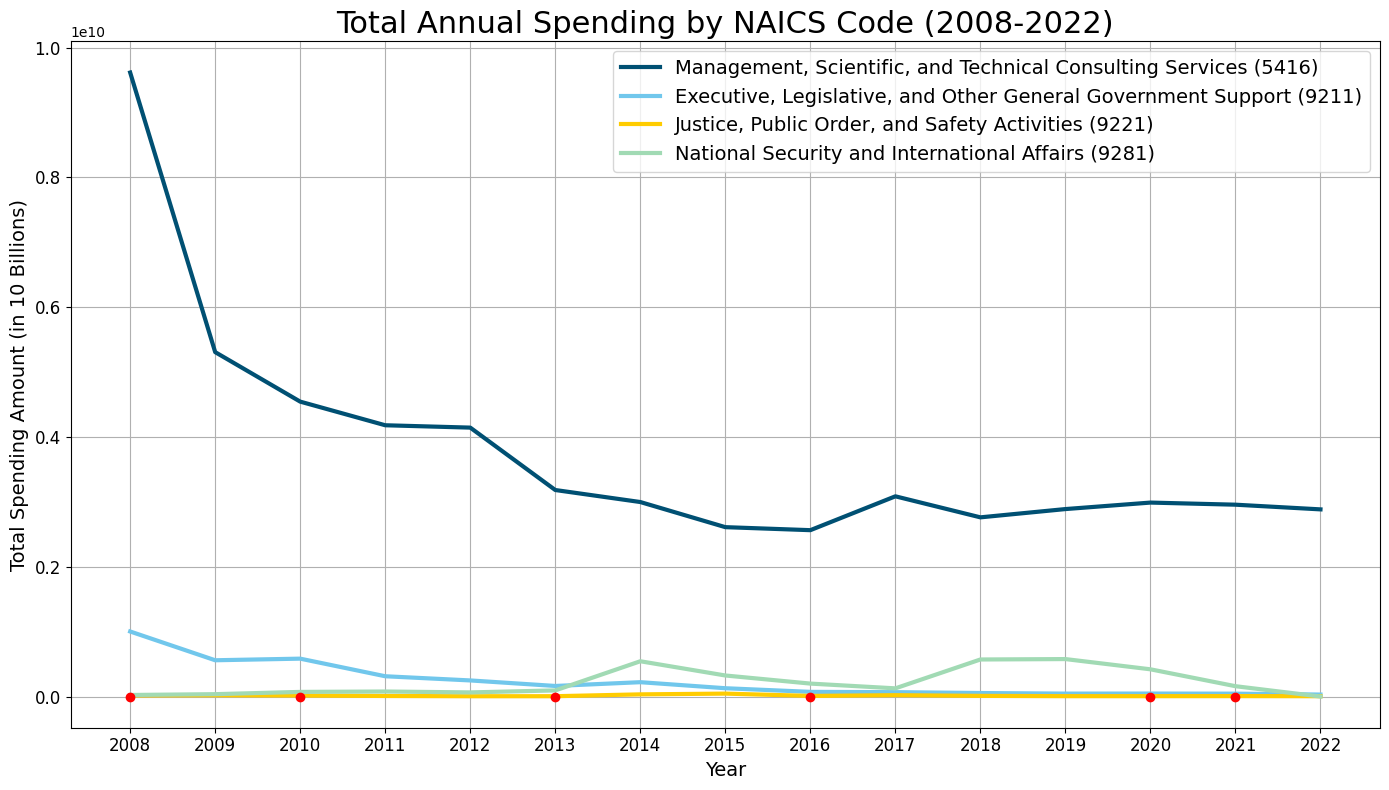

In [ ]:
import matplotlib.pyplot as plt

years = list(range(2008, 2023))
amounts_5416 = [spending_data["5416"][year] for year in years]
amounts_9211 = [spending_data["9211"][year] for year in years]
amounts_9221 = [spending_data["9221"][year] for year in years]
amounts_9281 = [spending_data["9281"][year] for year in years]

# Plotting the line chart with a more professional color palette
plt.figure(figsize=(14, 8))
colors = ["#005073", "#71c7ec", "#ffcc00", "#a1dab4"]  # Professional color palette

# Plotting thicker lines
plt.plot(years, amounts_5416, label='Management, Scientific, and Technical Consulting Services (5416)', color=colors[0], linewidth=3)
plt.plot(years, amounts_9211, label='Executive, Legislative, and Other General Government Support (9211)', color=colors[1], linewidth=3)
plt.plot(years, amounts_9221, label='Justice, Public Order, and Safety Activities (9221)', color=colors[2], linewidth=3)
plt.plot(years, amounts_9281, label='National Security and International Affairs (9281)', color=colors[3], linewidth=3)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Spending Amount (in 10 Billions)', fontsize=14)
plt.title('Total Annual Spending by NAICS Code (2008-2022)', fontsize=22)
plt.xticks(years, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)

# Annotating significant global events with red dots
event_years = [2008, 2010, 2013, 2016, 2020, 2021]  # Years of the events
for year in event_years:
    plt.plot(year, 0, 'ro')  # 'ro' for red dot


plt.grid(True)
plt.tight_layout()
plt.show()


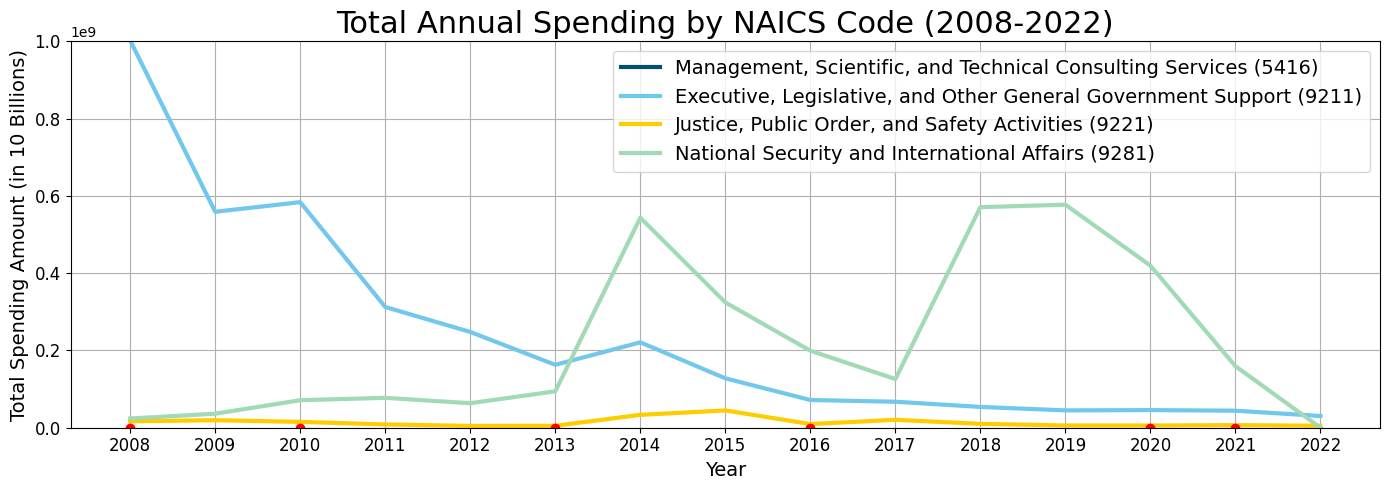

In [ ]:
import matplotlib.pyplot as plt

years = list(range(2008, 2023))
amounts_5416 = [spending_data["5416"][year] for year in years]
amounts_9211 = [spending_data["9211"][year] for year in years]
amounts_9221 = [spending_data["9221"][year] for year in years]
amounts_9281 = [spending_data["9281"][year] for year in years]

# Plotting the line chart with a more professional color palette
plt.figure(figsize=(14, 5))
colors = ["#005073", "#71c7ec", "#ffcc00", "#a1dab4"]  # Professional color palette

# Plotting thicker lines
plt.plot(years, amounts_5416, label='Management, Scientific, and Technical Consulting Services (5416)', color=colors[0], linewidth=3)
plt.plot(years, amounts_9211, label='Executive, Legislative, and Other General Government Support (9211)', color=colors[1], linewidth=3)
plt.plot(years, amounts_9221, label='Justice, Public Order, and Safety Activities (9221)', color=colors[2], linewidth=3)
plt.plot(years, amounts_9281, label='National Security and International Affairs (9281)', color=colors[3], linewidth=3)

plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Spending Amount (in 10 Billions)', fontsize=14)
plt.title('Total Annual Spending by NAICS Code (2008-2022)', fontsize=22)
plt.xticks(years, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)

# Annotating significant global events with red dots
event_years = [2008, 2010, 2013, 2016, 2020, 2021]  # Years of the events
for year in event_years:
    plt.plot(year, 0, 'ro')  # 'ro' for red dot

plt.ylim(0, 0.1e10)

plt.grid(True)
plt.tight_layout()
plt.show()
